In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime

In [5]:
from datetime import datetime, timedelta

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

In [7]:
sys.path.append("../code/")

In [8]:
import src

### parameters for papermill 

In [9]:
regions = ["NZ", "Ninos", "IOD"]
region = "NZ"
dpath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
ndays_agg = 1
ndays_back = 90
quantile = 0.9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
dpath = pathlib.Path(dpath).joinpath(region)
clim_path = pathlib.Path(clim_path).joinpath(region)

### get the current date 

In [11]:
current_date = datetime.utcnow()

### get the first day of the period to extract 

In [12]:
first_day = current_date - timedelta(days=ndays_back)

## get the years to read 

In [13]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [14]:
lfiles = [dpath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

## opens the near realtime dataset 

In [15]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords")

In [16]:
dset

<xarray.Dataset>
Dimensions:  (time: 220, lat: 80, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-08-08
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(220, 80, 72), meta=np.ndarray>

### get rid of the 29th of Feb if present 

In [17]:
dset = dset.convert_calendar("noleap")

### opens the climatology 

In [18]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{region}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [19]:
clim

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, dayofyear: 365, quantile: 5)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
Data variables:
    average    (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>
    quantiles  (dayofyear, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, dayofyear) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>

### calculate the anomalies with respect to the 1991-2020 average

In [20]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

### repeat the climatology over the time dimension 

In [21]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [22]:
clim_repeat

<xarray.Dataset>
Dimensions:    (lat: 80, lon: 72, time: 220, quantile: 5)
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 213 214 215 216 217 218 219 220
  * lat        (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon        (lon) float32 162.1 162.4 162.6 162.9 ... 179.1 179.4 179.6 179.9
  * quantile   (quantile) float64 0.1 0.25 0.5 0.75 0.9
  * time       (time) object 2022-01-01 00:00:00 ... 2022-08-08 00:00:00
Data variables:
    average    (lat, lon, time) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>
    quantiles  (time, quantile, lat, lon) float64 dask.array<chunksize=(92, 2, 20, 36), meta=np.ndarray>
    std        (lat, lon, time) float32 dask.array<chunksize=(20, 36, 183), meta=np.ndarray>

### derive the mask 

In [23]:
mask = dset["sst"].where(dset["sst"] >= clim_repeat["quantiles"].sel(quantile=quantile))
mask = mask.where(np.isnan(mask), other=1)

### Now select the maps to plot 

In [24]:
dataarray_anoms = anoms.isel(time=(-lag - 1))["sst"]

In [25]:
dataarray_raw = dset.isel(time=(-lag - 1))["sst"]

In [26]:
mask = mask.isel(time=(-lag - 1))

### Interpolate over the missing (land) grid points, for smooth plotting 

In [27]:
dataarray_anoms = src.interpolate_NaN_da(dataarray_anoms)

In [28]:
dataarray_raw = src.interpolate_NaN_da(dataarray_raw)

In [29]:
cmap = cmocean.cm.balance

In [41]:
def plot_SST_map(
    dataarray, mask, kind="anomalies", ndays_agg=1, cmap=None, stipples_color="k"
):

    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import cmocean

    if cmap is None:

        cmap = cmocean.cm.balance

    states_provinces = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces_lines",
        scale="10m",
        facecolor="none",
    )

    lakes = cfeature.NaturalEarthFeature("physical", "lakes", "10m")
    rivers = cfeature.NaturalEarthFeature("physical", "rivers_lake_centerlines", "10m")
    land = cfeature.NaturalEarthFeature("physical", "land", "10m")

    # get the min and max of the dataarray

    sst_range = np.round(dataarray_anoms.min(("lat", "lon")).data, 2), np.round(
        dataarray_anoms.max(("lat", "lon")).data, 2
    )

    date = datetime(
        *list(
            map(
                int,
                [
                    dataarray.time.dt.year,
                    dataarray.time.dt.month,
                    dataarray.time.dt.day,
                ],
            )
        )
    )

    f, ax = plt.subplots(
        figsize=(8, 8),
        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180.0)},
    )

    ax.coastlines("10m", linewidth=2)
    ax.add_feature(land, facecolor="gainsboro")
    ax.add_feature(lakes, facecolor="b", edgecolor="b", alpha=0.2)
    ax.add_feature(states_provinces, edgecolor="k", linewidth=1)

    if kind == "anomalies":

        title = f"OISST V2 {ndays_agg} days average anomalies* to {date:%Y-%m-%d}\n"

        cbar_label = "SST anomaly (°C)"

    dataarray.plot.contourf(
        ax=ax,
        levels=20,
        transform=ccrs.PlateCarree(),
        extend="both",
        cbar_kwargs={"shrink": 0.8, "pad": 0.05, "label": cbar_label},
        cmap=cmap,
    )

    cs = (dataarray * mask).plot.contourf(
        ax=ax,
        levels=20,
        transform=ccrs.PlateCarree(),
        colors="None",
        hatches=[".."],
        add_colorbar=False,
    )

    for i, collection in enumerate(cs.collections):

        collection.set_edgecolor(stipples_color)
        collection.set_linewidth(0.0)

    ax.set_title(None)

    ax.set_title(title, fontsize=14, loc="left", ha="left")
    ax.text(
        0.01,
        1.01,
        f"Max = {sst_range[1]:+4.2f}˚C | Min = {sst_range[0]:+4.2f}˚C",
        transform=ax.transAxes,
        ha="left",
        fontsize=12,
    )
    ax.text(
        0.01,
        -0.05,
        "*Marine heatwave conditions stippled",
        transform=ax.transAxes,
        ha="left",
        fontsize=12,
        color="k",
        style="italic",
    )

    return (f, ax)

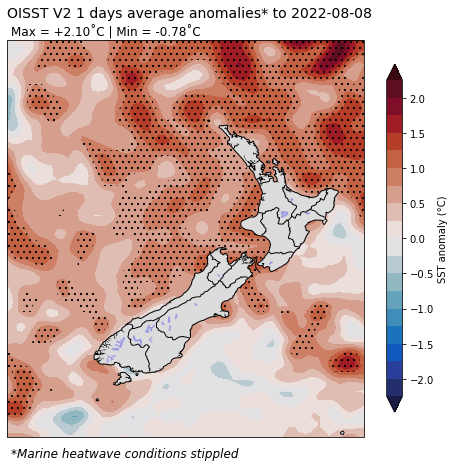

In [42]:
f, ax = plot_SST_map(dataarray_anoms, mask, ndays_agg=ndays_agg)

In [32]:
f.savefig(
    f"/home/nicolasf/Desktop/proto_OISST_anoms_{ndays_agg}_days.png", dpi=200, bbox_inches="tight", facecolor="w"
)

### calculates the regional averages 

In [ ]:
dset = src.calculates_ninos(dset, nino="all")

In [ ]:
if ndays_agg is not None:

    dset["sst"] = (
        dset["sst"]
        .rolling({"time": ndays_agg}, center=False, min_periods=ndays_agg)
        .mean("time")
    )

    dset = dset.isel(time=slice(ndays_agg + 1, None))

In [ ]:
dset

In [ ]:
dset.sel(nino="3.4")["sst"].plot()

In [ ]:
dset = dset.convert_calendar("noleap")

In [ ]:
dset

In [ ]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{region}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [ ]:
clim

### calculates the anomalies 

In [ ]:
anoms = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

In [ ]:
anoms.time.dt.dayofyear

In [ ]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

In [ ]:
clim_repeat

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
clim_repeat.sel(nino="3.4", quantile=0.25)["quantiles"].plot(ax=ax)
clim_repeat.sel(nino="3.4")["average"].plot(ax=ax)
dset.sel(nino="3.4")["sst"].plot(ax=ax)
ax.grid()

In [ ]:
anoms.sel(nino="3.4")["sst"].plot()

In [ ]:
ess = clim["quantiles"] - clim["average"]

In [ ]:
ess

In [ ]:
ess.sel(nino="3.4").plot()

In [ ]:
clim["quantiles"].sel(nino="3.4").plot()

In [ ]:
ess_repeat = ess.sel(dayofyear=anoms.time.dt.dayofyear)

In [ ]:
ess_repeat

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
ess_repeat.sel(nino="3.4", quantile=0.5).plot(ax=ax)
anoms.sel(nino="3.4")["sst"].plot(ax=ax)
ax.grid()